# You are breaking my heart

This dataset contains information on 303 patients. Several medically relevant data are available (age, sex, cholesterol, resting blood pressure...). Our task is to predict the presence of heart disease (column "target", 0 means healty, 1 means sick).

This dataset is described in detail:

* on Kaggle datasets: https://www.kaggle.com/ronitf/heart-disease-uci
* on its original webpage: https://archive.ics.uci.edu/ml/datasets/Heart+Disease

I've downloaded a copy of the data and made it available at the following url:

In [1]:
DATASET_URL = 'https://raw.githubusercontent.com/ne1s0n/coding_excercises/master/data/datasets_33180_43520_heart.csv'

# Battleplan

* load dataset
* a bit of data visualization/exploration
* a baseline classifier: logistic regression
* improve the data, improve the classifier
* a better NN classifier: let's add a layer
  * doing a proper crossvalidation


# Config

In [2]:
#let's fix already our desired number of epochs
EPOCHS = 200

To be sure to have the same results, we can fix the random seeds.

In [3]:
#resetting the seeds
!wget -O support_code.py https://raw.githubusercontent.com/ne1s0n/coding_excercises/master/lab_day1/support_code.py
%run support_code.py
n1 = 10
reset_random_seeds(n1)

--2025-10-29 14:47:12--  https://raw.githubusercontent.com/ne1s0n/coding_excercises/master/lab_day1/support_code.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6242 (6.1K) [text/plain]
Saving to: ‘support_code.py’

support_code.py     100%[===================>]   6.10K  --.-KB/s    in 0s      

2025-10-29 14:47:12 (74.2 MB/s) - ‘support_code.py’ saved [6242/6242]

Import all libraries: yes
importing libraries
Defining functions
DONE!


# Data

In [4]:
import pandas

#pandas can read a csv directly from a url
heart_data = pandas.read_csv(DATASET_URL)
print(heart_data)

     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   3       145   233    1        0      150      0      2.3   
1     37    1   2       130   250    0        1      187      0      3.5   
2     41    0   1       130   204    0        0      172      0      1.4   
3     56    1   1       120   236    0        1      178      0      0.8   
4     57    0   0       120   354    0        1      163      1      0.6   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   57    0   0       140   241    0        1      123      1      0.2   
299   45    1   3       110   264    0        1      132      0      1.2   
300   68    1   0       144   193    1        1      141      0      3.4   
301   57    1   0       130   131    0        1      115      1      1.2   
302   57    0   1       130   236    0        0      174      0      0.0   

     slope  ca  thal  target  
0        0   0     1       1  
1        0   0     2     

In [5]:
#splitting features and target
features = heart_data.iloc[:,:-1] ## takes all columns except the last one (starts counting from 0)
target = heart_data.iloc[:,-1] ## takes last column (starts counting from 0)

In [6]:
#take a look at what we have done
print(heart_data.columns)
print(features.shape)
print(target.shape) #beware of rank 1 arrays

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')
(303, 13)
(303,)


## Train and Validation sets

In [7]:
#we want to have the same proportion of classes in both train and validation sets
from sklearn.model_selection import StratifiedShuffleSplit

#building a StratifiedShuffleSplit object (sss among friends) with 20% data
#assigned to validation set (here called "test")
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

#the .split() method returns (an iterable over) two lists which can be
#used to index the samples that go into train and validation sets
for train_index, val_index in sss.split(features, target):
    features_train = features.iloc[train_index, :]
    features_val   = features.iloc[val_index, :]
    target_train   = target[train_index]
    target_val     = target[val_index]

#let's print some shapes to get an idea of the resulting data structure
print(features_train.shape)
print(features_val.shape)
print(target_train.shape)
print(target_val.shape)

(242, 13)
(61, 13)
(242,)
(61,)


# Baseline predictor: logistic regression

In [8]:
#we are building a "sequential" model, meaning that the data will
#flow like INPUT -> ELABORATION -> OUTPUT. In other words, there
#we will not be any loops, i.e. our output will never be recycled as
#input for the first layer. That would make the architecture
#recurrent, which we don't want since the data is tabular and
#recurrent networks are more suited for streams and sequences of data
from keras.models import Sequential

#a "dense" layer is a layer were all the data coming in are connected
#to all nodes. In our case there is only one node in the layer, and
#it receives all the features.
#Doc: https://keras.io/api/layers/core_layers/dense/
from keras.layers import Dense
#Doc: https://keras.io/api/layers/core_layers/input/
from keras.layers import Input


#this is optional: we'll add some extra metrics which are more human
#readable than crossentropy, so to have a practical feeling about
#how well the model is doing
import keras.metrics

# 2-class logistic regression in Keras
model = Sequential()
model.add(Input((features_train.shape[1],))) #13
model.add(Dense(1, activation='sigmoid'))

#the model is declared, but we still need to compile it to actually
#build all the internal data structures. Moreover, we still need to
#specify optimizer, loss function and, optionally, extra metrics
model.compile(optimizer='rmsprop', loss='binary_crossentropy',
    metrics=[
      keras.metrics.BinaryAccuracy(),
      keras.metrics.AUC(name='auc'),
    ])

At this point we are ready to train. You may have noticed that so far we just described the architecture. It's now time to have the network meed train and validation data.

In [9]:
#doc: https://keras.io/api/models/model_training_apis/#fit-method
history = model.fit(
    x = features_train,
    y = target_train,
    epochs = 10,
    validation_data = (features_val, target_val),
    verbose=1)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - auc: 0.3779 - binary_accuracy: 0.4344 - loss: 9.5008 - val_auc: 0.2917 - val_binary_accuracy: 0.4098 - val_loss: 8.3892
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - auc: 0.3585 - binary_accuracy: 0.3877 - loss: 7.5113 - val_auc: 0.2971 - val_binary_accuracy: 0.3115 - val_loss: 7.8814
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - auc: 0.3246 - binary_accuracy: 0.3779 - loss: 6.8982 - val_auc: 0.2911 - val_binary_accuracy: 0.3443 - val_loss: 7.7814
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.3252 - binary_accuracy: 0.3716 - loss: 6.6735 - val_auc: 0.2760 - val_binary_accuracy: 0.3115 - val_loss: 7.7542
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.3251 - binary_accuracy: 0.3682 - loss: 6.5673 - val_auc: 0.2560 - val_binary_accuracy: 0.3115 - val_loss: 7.7273
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - auc: 0.3321 - binary_accuracy: 0.3618 - loss: 6.4958 - val_auc: 0.2587 - val_binary_accuracy: 

In [10]:
#Taking a look to what's inside the returned history dictionary
print(history.history.keys())

dict_keys(['auc', 'binary_accuracy', 'loss', 'val_auc', 'val_binary_accuracy', 'val_loss'])


In [11]:
#function to plot losses and metrics evolution
import matplotlib.pyplot as plt
def plot_loss_history(h, title):
  for metric in h.history.keys():
    #ignoring metrics on validation set, which are implied when
    #plotting on training set
    if metric.startswith('val_'):
      continue

    #if we get here we found a metric on the training set,
    #let's plot it
    plt.plot(h.history[metric], label = "Train set")
    plt.plot(h.history["val_" + metric], label = "Validation set")
    plt.xlabel('Epochs')
    plt.title(title + ' - ' + metric)
    plt.legend()
    plt.show()

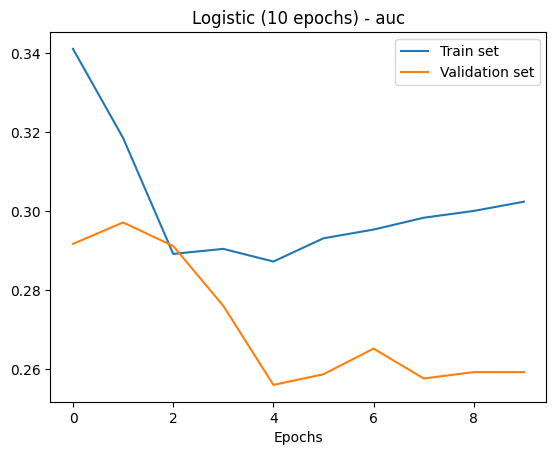

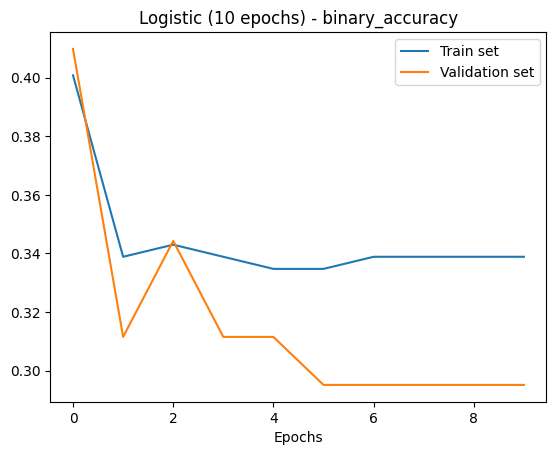

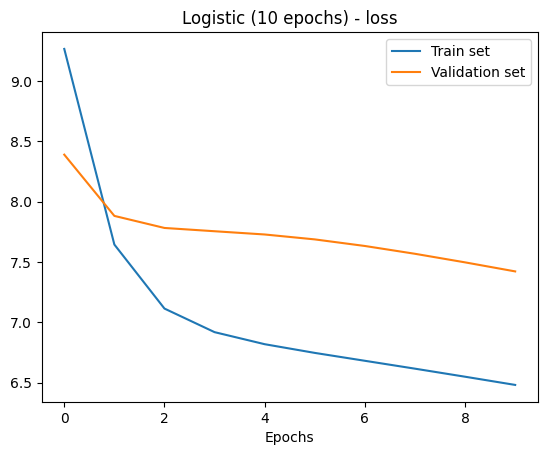

In [12]:
plot_loss_history(history, 'Logistic (10 epochs)')

In [13]:
#putting verbose to 0 to avoid filling the screen
history2 = model.fit(features_train, target_train, epochs=(EPOCHS - 10),
                     validation_data=(features_val, target_val), verbose=0)

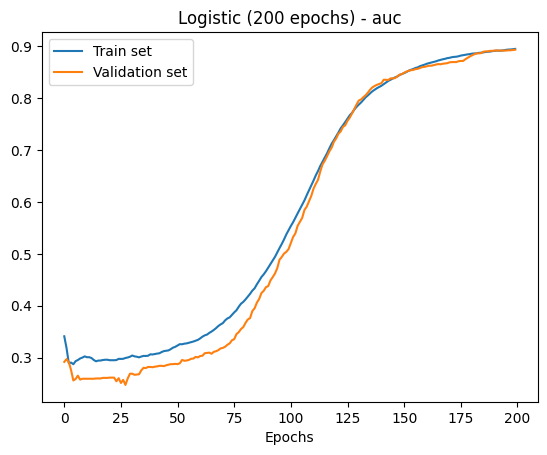

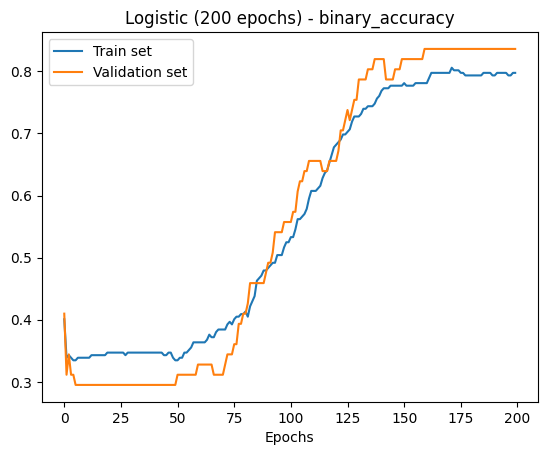

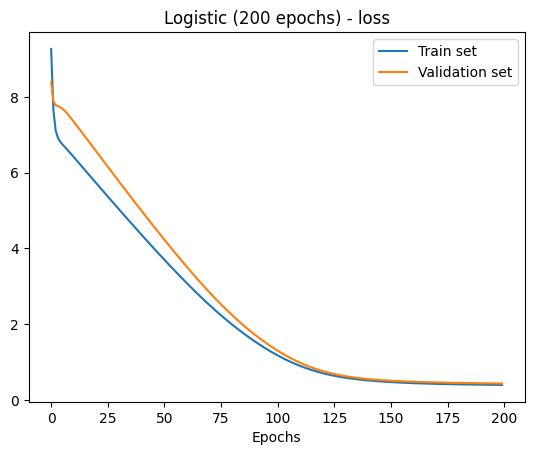

In [14]:
#putting together the whole history
for k in history.history.keys():
  history.history[k] += history2.history[k]

#and plotting again
plot_loss_history(history, 'Logistic (' + str(EPOCHS) + ' epochs)')

Taking a look to the [confusion matrix](https://www.analyticssteps.com/blogs/what-confusion-matrix)

In [15]:
#sklearn provides a function to compute the confusion
#matrix given two numpy arrays: the true labels and
#the predicted labels
#doc: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
from sklearn.metrics import confusion_matrix

#first: let's get the predictions for our validation set
predictions = model.predict(features_val)

#taking a look at the first few ones
print(predictions[1:5])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[0.8982971 ]
 [0.9361193 ]
 [0.98316985]
 [0.9902801 ]]


At this stage predictions are numbers in the [0,1] range. That's expected, since it's the normal output of a sigmoid (a.k.a. a logistic function).

To change them in labels (healty/sick) we need to discretyze. Everything above 0.5 goes to one, everything below goes to zero. In this way it will be comparable to true labels, which are naturally in the {zero, one} set.

In [16]:
import numpy

#using numpy "where" function to do substitutions
#doc: https://numpy.org/doc/stable/reference/generated/numpy.where.html
predicted_labels = numpy.where(predictions > 0.5, 1, 0)

#computing and printing the matrix
con_mat_df = confusion_matrix(target_val, predicted_labels)
print(con_mat_df)

[[22  6]
 [ 4 29]]


# Improvement: data normalization

In [17]:
#getting an idea about features averages, sd
avg = features_train.mean()
std = features_train.std()
print('Feature means')
print(avg)
print('\nFeature standard deviations')
print(std)

Feature means
age          54.413223
sex           0.710744
cp            0.995868
trestbps    131.690083
chol        244.066116
fbs           0.169421
restecg       0.545455
thalach     149.342975
exang         0.314050
oldpeak       1.012810
slope         1.384298
ca            0.743802
thal          2.314050
dtype: float64

Feature standard deviations
age          9.022949
sex          0.454357
cp           1.040659
trestbps    17.492827
chol        51.093233
fbs          0.375901
restecg      0.531185
thalach     23.220085
exang        0.465098
oldpeak      1.135380
slope        0.622071
ca           1.038902
thal         0.624972
dtype: float64


In [18]:
#IMPORTANT: normalizing features using the same weights for both
#train and validation sets. This is the hardest condition. For a
#simpler problem compute avg and std on the full dataset.
#QUESTION: why?
features_train = (features_train - avg)/std
features_val = (features_val - avg)/std

# Improvement: class balancing

In [19]:
#comparing the number of samples for each class
N_TOT = target_train.shape[0]
N_DISEASE = target_train.sum()
N_NORMAL = N_TOT - N_DISEASE

print('Total samples: ' + str(N_TOT) + ' (normal:' + str(N_NORMAL) + ' diseases:' + str(N_DISEASE) + ')')

Total samples: 242 (normal:110 diseases:132)


We propose a "in-house" class balancing function. There's a more complicated (and effective) one in sklearn called [compute_class_weight()](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html)

In [20]:
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit and
#whatch for argument class_weight

#handy function, to be reused later
def get_weights(target):
  #counting the number of instances for each class
  class_1_cnt = target_train.sum()
  class_0_cnt = target.shape[0] - target_train.sum()

  #we get weights as inverse of class ratios
  weight_for_0 = (class_0_cnt + class_1_cnt) / class_0_cnt
  weight_for_1 = (class_0_cnt + class_1_cnt) / class_1_cnt

  #and we are done
  return({0: weight_for_0, 1: weight_for_1})


#let's we invoke the function right away
class_weight = get_weights(target_train)
print('Computed weights:' + str(class_weight))

Computed weights:{0: np.float64(2.2), 1: np.float64(1.8333333333333333)}


# Improvement: better model

In [21]:
#let's keep it simple: adding a Dense ReLU layer

# 2-class logistic regression in Keras
model2 = Sequential()
model2.add(Input((features_train.shape[1],)))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

#the model is declared, but we still need to compile it to actually
#build all the data structures
model2.compile(optimizer='rmsprop', loss='binary_crossentropy',
    metrics=[
      keras.metrics.BinaryAccuracy(),
      keras.metrics.AUC(),
    ])

# Train again!

In [22]:
print(target_train)

269    0
191    0
15     1
224    0
250    0
      ..
142    1
33     1
181    0
262    0
54     1
Name: target, Length: 242, dtype: int64


In [23]:
#train with normalized data, class weights, improved model, same epochs
history_m2 = model2.fit(
    x = features_train,
    y = target_train.to_numpy(),
    epochs=EPOCHS,
    validation_data = (features_val, target_val.to_numpy()),
    class_weight = class_weight,
    verbose=0)

In [24]:
print(type(target_train.to_list()))

<class 'list'>


Confusion matrix for second model

In [25]:
predictions = model2.predict(features_val)
predicted_labels = numpy.where(predictions > 0.5, 1, 0)
con_mat_df = confusion_matrix(target_val, predicted_labels)
print(con_mat_df)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[25  3]
 [ 3 30]]


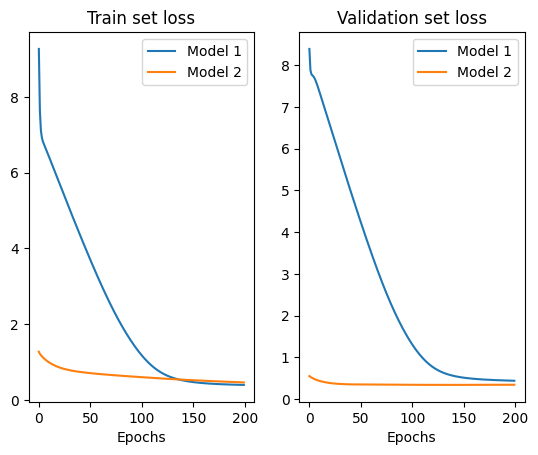

In [26]:
#a direct comparison of loss functions
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Model 1')
plt.plot(history_m2.history['loss'], label='Model 2')
plt.title('Train set loss')
plt.legend()
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Model 1')
plt.plot(history_m2.history['val_loss'], label='Model 2')
plt.title('Validation set loss')
plt.legend()
plt.xlabel('Epochs')

plt.show()

In [27]:
#taking a look at final val accuracy

print('Binary accuracy on validation set')
print('Model 1) ' + str(history.history['val_binary_accuracy'][-1]))
print('Model 2) ' + str(history_m2.history['val_binary_accuracy'][-1]))

print('\nLoss on validation set')
print('Model 1) ' + str(history.history['val_loss'][-1]))
print('Model 2) ' + str(history_m2.history['val_loss'][-1]))

Binary accuracy on validation set
Model 1) 0.8360655903816223
Model 2) 0.9016393423080444

Loss on validation set
Model 1) 0.43770304322242737
Model 2) 0.341979056596756


---
# END OF INTERACTIVE PART

(code below this point is a bit too slow for class)

---

# Improvement: fine tuning number of units

We want to add more units to our hidden layer. How many? This is our first true HYPERPARAMETER. To tune it we'll implement a five-folds crossvalidation scheme. BUT we'll need a new, pristine piece of data to actually evaluate the performances. It's time to introduce...

## Train, validation and TEST sets!

<img src="https://drive.google.com/uc?id=1-9uP7NfHGUx-TtZzKcil3W6ehx28YRCI" width=600/>

In [28]:
#support function to have a leaner code down below:
#input: train set, test set, number of units in the hidden layer
#output: train history object

def train_NN(feat_tr, feat_val, tar_tr, tar_val, n_units):
    #same 1 hidden layer model as above
    m = Sequential()
    m.add(Input((feat_tr.shape[1],)))
    m.add(Dense(units = n_units, activation='relu'))
    m.add(Dense(1, activation='sigmoid'))

    #the model is declared, but we still need to compile it to actually
    #build all the data structures
    m.compile(optimizer='rmsprop', loss='binary_crossentropy',
        metrics=[
          keras.metrics.BinaryAccuracy(),
          keras.metrics.AUC(name='auc'),
        ])

    #compute class weights for this specific split
    cw = get_weights(tar_tr)

    #ready to train!
    h = m.fit(
      feat_tr, tar_tr.to_numpy(),
      epochs=EPOCHS,
      validation_data=(feat_val, tar_val.to_numpy()),
      class_weight = cw,
      verbose=0)

    #and we are done
    return(h)

In [30]:
#we now further split the train set to do a proper crossvalidation using
#again scikit-learn, but this time we want the indexes for each split
#so we are going to instantiate a StratifiedKFold object
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits = 5)

#as done above, the .split() method returns (an iterable over) two lists which
#can be used to index the samples that go into train and test sets

#a loop tracker, useful for indexing and printing messages
fold = 0

#room to store all the training histories
all_histories = {}

#let's explore these possible number of units
layer_units = [2, 4, 8, 16, 32]

#loop over folds
for train_index_cv, test_index_cv in skf.split(features_train, target_train):
    features_train_cv = features_train.iloc[train_index_cv, :]
    features_test_cv  = features_train.iloc[test_index_cv, :]
    target_train_cv   = target_train.iloc[train_index_cv]
    target_test_cv    = target_train.iloc[test_index_cv]

    #user interface
    fold += 1
    print('Doing fold ' + str(fold))

    #room to store all the training histories
    all_histories[fold] = {}

    #loop over considered number of units
    for lu in layer_units:
      #user interface
      print(' - training with lu=' + str(lu))

      #training the network, storing the training history
      all_histories[fold][lu] = train_NN(
          features_train_cv, features_test_cv,
          target_train_cv, target_test_cv, lu)


Doing fold 1
 - training with lu=2
 - training with lu=4
 - training with lu=8
 - training with lu=16
 - training with lu=32
Doing fold 2
 - training with lu=2
 - training with lu=4
 - training with lu=8
 - training with lu=16
 - training with lu=32
Doing fold 3
 - training with lu=2
 - training with lu=4
 - training with lu=8
 - training with lu=16
 - training with lu=32
Doing fold 4
 - training with lu=2
 - training with lu=4
 - training with lu=8
 - training with lu=16
 - training with lu=32
Doing fold 5
 - training with lu=2
 - training with lu=4
 - training with lu=8
 - training with lu=16
 - training with lu=32


In [31]:
#all_histories is a bit messy, order of indexing is:
#fold -> number of units -> actual history object
#let's take a look at all these indexes:
print(all_histories.keys())
print(all_histories[1].keys())
print(all_histories[1][16].history.keys())

dict_keys([1, 2, 3, 4, 5])
dict_keys([2, 4, 8, 16, 32])
dict_keys(['auc', 'binary_accuracy', 'loss', 'val_auc', 'val_binary_accuracy', 'val_loss'])


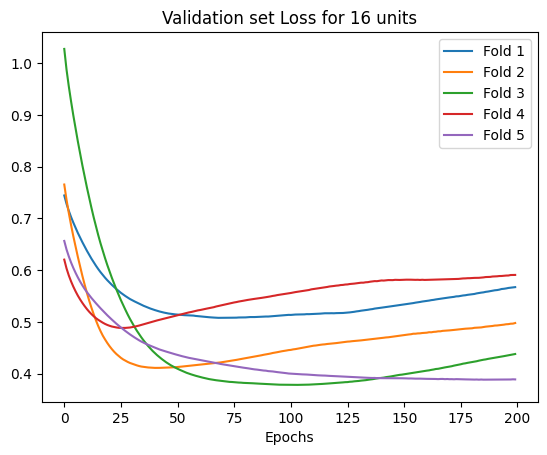

In [32]:
#for each considered number of units we have five different executions
#let's take a look at one
lu = 16
plt.plot(all_histories[1][lu].history['val_loss'], label = 'Fold 1')
plt.plot(all_histories[2][lu].history['val_loss'], label = 'Fold 2')
plt.plot(all_histories[3][lu].history['val_loss'], label = 'Fold 3')
plt.plot(all_histories[4][lu].history['val_loss'], label = 'Fold 4')
plt.plot(all_histories[5][lu].history['val_loss'], label = 'Fold 5')
plt.xlabel('Epochs')
plt.title('Validation set Loss for ' + str(lu) + ' units')
plt.legend()
plt.show()

In [33]:
#let's forget history and focus on metrics for last epoch
#also: let's average over folds

rows = []
for lu in layer_units:
  for fold in all_histories.keys():
    row = []
    row.append(lu)
    row.append(all_histories[fold][lu].history['val_loss'][-1])
    row.append(all_histories[fold][lu].history['val_binary_accuracy'][-1])
    row.append(all_histories[fold][lu].history['val_auc'][-1])
    rows.append(row)

#converting to pandas
df = pandas.DataFrame(rows, columns=["LU", "loss", "accuracy", "AUC"])

#average over folds
df = df.groupby(df['LU']).aggregate('mean')

#and take a look to the numbers
print(df)

        loss  accuracy       AUC
LU                              
2   0.515563  0.768282  0.880012
4   0.437067  0.805867  0.901437
8   0.463261  0.813946  0.888895
16  0.496641  0.776871  0.880886
32  0.585970  0.793282  0.879079


In [34]:
#selecting LU with best loss
LU_selected = df.loc[:, 'loss'].idxmin()
print('Best performance with ' + str(LU_selected) + ' units in the hidden layer')

Best performance with 4 units in the hidden layer


In [38]:
#train again, this time using the full train set, and evaluating in the test set
history_m3 = train_NN(
    features_train, features_val,
    target_train, target_val,
    LU_selected)

#taking a look at the final validation loss, even if the comparison it's a
#bit unfair (can you tell why?)
print('Model 1) ' + str(history.history['val_loss'][-1]))
print('Model 2) ' + str(history_m2.history['val_loss'][-1]))
print('Model 3) ' + str(history_m3.history['val_loss'][-1]))

Model 1) 0.43770304322242737
Model 2) 0.341979056596756
Model 3) 0.39239928126335144
